# ETL de los datos

## Importar librarías

En este caso se importan las librerías de pandas para la manipulación de los datos en CSV en forma de DataFrames, y la librería os para leer los archivos de datos del proyecto

In [39]:
import pandas as pd
import os # To read raw data

## Leer conjunto de datos

Los datos de INEGI sobre las estadísticas de divorcios del año 2017 al 2023 están distribuídos en 7 archivos diferentes. Aquí se crea una lista de DataFrames que contienen todos los conjuntos de datos de los archivos. Los conjuntos de datos se encuentran en la carpeta `/data/raw_data/`, por lo que se itera cada uno de los archivos que están en esta carpeta y, con la ruta del archivo, se lee cada uno de los CSV para crear un DF diferente.

Antes de agregar el DF en la lista de los dataframes, se convierten los nombres de las columnas a minúsculas, ya que, aunque todos los archivos comparten la manera en que registran los divorcios, hay diferentes archivos como el del año 2017 que tienen los nombres de las columnas en mayúsculas.

In [40]:
# divorces_in_2023 = pd.read_csv("data/raw_data/conjunto_de_datos_ed2023.csv", header=0)

dataframes = []
directory_path = "data/raw_data/"

for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)
        df.columns = df.columns.str.lower()
        dataframes.append(df)

len(dataframes)
# dataframes["conjunto_de_datos_divorcios_2017"]

7

A continuación, se tiene una visualización previa de cada uno de los conjuntos de datos:

In [41]:
dataframes[0]

,tipo_div,ent_regis,mun_regis,loc_regis,tloc_regis,ent_mat,mun_mat,local_mat,tloc_mat,dia_mat,...,con_acdiv2,dedic_div2,postr_div2,sexo_div2,dura_soc,dura_leg,edad_mdiv1,edad_mdiv2,t_dvante,dis_reoax
0,1,1,1,1,15,1,1,9999,99,99,...,1,1,7,2,99,99,99,99,1,998
1,1,1,1,1,15,1,1,1,15,99,...,1,1,1,2,99,99,99,99,1,998
2,1,1,1,1,15,1,1,1,15,99,...,2,2,9,2,99,99,99,99,1,998
3,1,1,1,1,15,1,7,30,4,99,...,1,1,1,2,99,99,99,99,1,998
4,1,1,1,1,15,1,1,1,15,99,...,1,1,1,2,99,99,99,99,1,998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160102,2,32,17,1,13,32,17,1,13,16,...,9,9,9,2,99,3,49,42,1,998
160103,2,32,10,1,13,32,10,1,13,1,...,9,9,9,2,99,5,19,20,1,998
160104,2,32,17,1,13,32,17,1,13,4,...,9,9,9,2,99,96,24,99,1,998
160105,2,32,17,1,13,32,17,1,13,28,...,9,9,9,2,99,2,31,27,1,998


In [42]:
dataframes[1]

,tipo_div,ent_regis,mun_regis,loc_regis,tloc_regis,ent_mat,mun_mat,local_mat,tloc_mat,dia_mat,...,con_acdiv2,dedic_div2,postr_div2,sexo_div2,dura_soc,dura_leg,edad_mdiv1,edad_mdiv2,t_dvante,dis_reoax
0,1,1,1,1,15,1,5,1,11,99,...,9,9,9,1,99,99,99,99,1,998
1,1,1,1,1,15,1,5,41,6,99,...,9,9,9,2,99,99,99,99,1,998
2,1,1,7,1,9,1,9,1,5,99,...,9,9,9,1,99,99,99,99,1,998
3,1,1,1,1,15,14,53,1,13,29,...,2,2,9,2,55,55,20,17,1,998
4,1,1,7,1,9,1,9,1,5,19,...,1,1,2,1,54,54,99,99,1,998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149670,2,32,55,1,6,32,55,1,6,20,...,2,8,9,2,99,36,22,24,1,998
149671,2,32,55,1,6,32,55,1,6,9,...,2,8,9,2,99,49,25,21,1,998
149672,2,32,20,1,10,32,20,1,10,25,...,9,9,9,2,99,1,35,33,1,998
149673,2,32,20,1,10,32,21,1,2,24,...,9,9,9,2,99,44,21,17,1,998


In [43]:
dataframes[2]

,tipo_div,ent_regis,mun_regis,loc_regis,tloc_regis,ent_mat,mun_mat,local_mat,tloc_mat,dia_mat,...,con_acdiv2,dedic_div2,postr_div2,sexo_div2,dura_soc,dura_leg,edad_mdiv1,edad_mdiv2,t_dvante,dis_reoax
0,1,1,1,1,15,15,114,1,4,99,...,9,9,9,1,99,99,99,99,1,998
1,1,1,1,1,15,1,1,1,15,99,...,1,1,1,1,99,99,99,99,1,998
2,1,1,1,1,15,1,1,1,15,8,...,9,9,9,2,55,56,99,99,1,998
3,1,1,1,1,15,1,1,1,15,17,...,2,4,9,1,55,56,99,21,1,998
4,1,1,1,1,15,32,17,1,13,24,...,9,9,9,2,54,54,17,99,1,998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163582,2,32,17,1,13,32,17,1,13,8,...,9,9,9,2,99,1,29,26,1,998
163583,2,32,17,1,13,32,17,1,13,30,...,9,9,9,2,99,98,45,58,1,998
163584,2,32,17,1,13,32,17,1,13,1,...,1,1,1,2,99,4,39,25,1,998
163585,2,32,17,1,13,32,17,1,13,12,...,9,9,9,2,99,22,34,28,1,998


In [44]:
dataframes[3]

,tipo_div,ent_regis,mun_regis,loc_regis,tloc_regis,ent_mat,mun_mat,local_mat,tloc_mat,dia_mat,...,con_acdiv2,dedic_div2,postr_div2,sexo_div2,dura_soc,dura_leg,edad_mdiv1,edad_mdiv2,t_dvante,dis_reoax
0,1,1,7,1,8,9,15,1,15,99,...,1,1,1,1,99,99,99,99,1,998
1,1,1,7,1,8,9,15,1,15,99,...,2,2,9,2,99,99,99,99,1,998
2,1,1,6,1,8,1,8,1,4,99,...,9,9,9,1,99,99,99,99,1,998
3,1,1,1,1,15,14,35,1,8,9,...,2,2,9,2,62,62,23,17,1,998
4,1,1,7,1,8,1,1,1,15,17,...,2,2,9,2,56,56,17,13,1,998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147576,1,32,56,1,13,32,56,1,13,99,...,9,9,9,2,94,96,23,20,1,998
147577,1,32,56,1,13,32,17,1,13,12,...,1,1,1,1,95,96,29,34,1,998
147578,1,32,20,1,10,32,20,1,10,99,...,1,1,1,2,98,98,46,39,1,998
147579,1,32,56,1,13,32,56,1,13,99,...,1,1,1,2,98,98,27,25,1,998


In [45]:
dataframes[4]

,tipo_div,ent_regis,mun_regis,loc_regis,tloc_regis,ent_mat,mun_mat,local_mat,tloc_mat,dia_mat,...,con_acdiv2,dedic_div2,postr_div2,sexo_div2,dura_soc,dura_leg,edad_mdiv1,edad_mdiv2,t_dvante,dis_reoax
0,1,1,1,1,15,1,1,1,15,13,...,9,9,9,2,62,63,18,99,1,998
1,1,1,1,1,15,15,24,7777,5,4,...,2,2,9,2,55,55,13,99,1,998
2,1,1,1,1,15,1,1,239,4,12,...,1,1,1,2,55,55,20,21,1,998
3,1,1,1,1,15,1,1,1,15,10,...,9,9,9,1,54,54,21,99,1,998
4,1,1,1,1,15,32,52,102,2,1,...,2,2,9,2,54,54,19,16,1,998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156551,1,32,38,1,5,32,54,1,4,2,...,1,1,2,1,96,98,35,32,1,998
156552,1,32,56,1,13,32,56,1,13,14,...,1,1,1,2,95,98,21,19,1,998
156553,1,32,5,1,9,32,5,1,9,3,...,2,2,9,2,96,97,58,41,1,998
156554,1,32,5,1,9,32,32,1,5,8,...,1,1,7,1,96,97,99,29,1,998


In [46]:
dataframes[5]

,tipo_div,ent_regis,mun_regis,loc_regis,tloc_regis,ent_mat,mun_mat,local_mat,tloc_mat,dia_mat,...,con_acdiv2,dedic_div2,postr_div2,sexo_div2,dura_soc,dura_leg,edad_mdiv1,edad_mdiv2,t_dvante,dis_reoax
0,1,1,6,1,9,1,1,1,15,99,...,1,1,3,1,99,99,99,99,1,998
1,1,1,6,1,9,1,6,1,9,11,...,9,9,9,2,60,60,24,99,1,998
2,1,1,6,1,9,1,6,1,9,28,...,2,4,9,1,59,59,19,18,1,998
3,1,1,6,1,9,1,11,1,7,5,...,2,8,9,1,55,56,18,25,1,998
4,1,1,1,1,15,32,56,1,13,21,...,2,4,9,2,55,55,25,23,1,998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92734,2,32,10,1,13,32,10,1,13,8,...,9,9,9,2,9,9,21,19,1,998
92735,2,32,10,1,13,32,10,1,13,18,...,9,9,9,2,96,96,24,24,1,998
92736,2,32,10,1,13,32,10,1,13,6,...,9,9,9,2,5,5,29,27,1,998
92737,2,32,10,1,13,32,10,1,13,28,...,2,2,9,2,17,17,18,17,1,998


In [47]:
dataframes[6]

,tipo_div,ent_regis,mun_regis,loc_regis,tloc_regis,ent_mat,mun_mat,local_mat,tloc_mat,dia_mat,...,con_acdiv2,dedic_div2,postr_div2,sexo_div2,dura_soc,dura_leg,edad_mdiv1,edad_mdiv2,t_dvante,dis_reoax
0,1,1,1,1,15,1,3,1,8,99,...,1,1,7,2,99,99,99,99,1,998
1,1,1,1,1,15,1,10,80,1,27,...,9,9,9,1,60,61,99,99,1,998
2,1,1,1,1,15,32,54,1,4,26,...,9,9,9,2,60,60,21,99,1,998
3,1,1,1,1,15,1,1,1,15,26,...,2,2,9,2,61,61,23,20,1,998
4,1,1,1,1,15,14,53,1,13,22,...,2,2,9,2,59,60,18,17,1,998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166761,2,32,17,1,13,32,17,1,13,15,...,1,1,1,2,99,54,19,16,1,998
166762,2,32,10,1,13,32,10,1,13,27,...,1,1,1,2,99,3,26,26,1,998
166763,2,32,17,1,13,32,17,1,13,19,...,1,1,1,2,99,3,24,24,1,998
166764,2,32,17,1,13,32,17,1,13,21,...,1,1,7,2,99,10,45,32,1,998


También se tiene que tomar en cuenta los catálogos de los datos para realizar la relación entre las claves encontradas en el conjunto de datos y los catálogos

In [48]:
pd.read_csv("data/catalogs/tipo_divorcio.csv", dtype={"clave": int})

,clave,descripción
0,1,Judicial
1,2,Administrativo


In [49]:
pd.read_csv("data/catalogs/a_favor.csv", dtype={"clave": int})

,clave,descripción
0,1,Divorciante 1
1,2,Divorciante 2
2,3,Ambos
3,9,No especificado


In [50]:
pd.read_csv("data/catalogs/causas_divorcio.csv", dtype={"clave": int})

,clave,descripción
0,1,Mutuo consentimiento
1,2,Adulterio o infidelidad sexual
2,3,Alumbramiento ilegítimo
3,4,Propuesta de prostitución
4,5,Incitación a la violencia
5,6,Corrupción y/o maltrato a los hijos
6,7,"Enfermedad crónica o incurable, la impotencia ..."
7,8,Enajenación mental incurable o el estado de in...
8,9,Separación del hogar conyugal por más de 1 año...
9,10,"Abandono de hogar por más de 3 o 6 meses, sin ..."


In [51]:
pd.read_csv("data/catalogs/condicion_actividad_economica.csv", dtype={"clave": int})

,clave,descripción
0,1,Trabaja
1,2,No trabaja
2,9,No especificada


In [52]:
pd.read_csv("data/catalogs/condicion_biologica.csv", dtype={"clave": int})

,clave,descripción
0,1,Hombre
1,2,Mujer


In [53]:
pd.read_csv("data/catalogs/custodia.csv", dtype={"clave": int})

,clave,descripción
0,0,No se otorga
1,1,Divorciante 1
2,2,Divorciante 2
3,3,Ambos
4,4,Otro
5,98,No aplica
6,99,No especificado


In [54]:
pd.read_csv("data/catalogs/dedicado_a.csv", dtype={"clave": int})

,clave,descripción
0,1,Trabaja
1,2,Al hogar
2,3,Estudiante
3,4,Pensionado o jubilado
4,5,Rentista
5,6,Incapacitado permanentemente para trabajar
6,7,Busca trabajo
7,8,Otra (no trabaja)
8,9,No especificada


In [55]:
pd.read_csv("data/catalogs/duracion_matrimonio.csv", dtype={"clave": int})

,clave,descripción
0,1,Un año
1,2,Dos años
2,3,Tres años
3,4,Cuatro años
4,5,Cinco años
...,...,...
94,95,De 3 meses
95,96,De 4 a 5 meses
96,97,De 6 meses
97,98,De 7 a 11 meses


In [56]:
# Funciona igual para todos los conjuntos de datos
pd.read_csv("data/catalogs/entidad_municipio_localidad_2023.csv", dtype={"clave": int})

,cve_ent,cve_mun,cve_loc,nom_loc
0,1,0,0,Aguascalientes
1,1,1,0,Aguascalientes
2,1,1,1,Aguascalientes
3,1,1,127,Los Caños
4,1,1,139,Cieneguilla (La Lumbrera)
...,...,...,...,...
9061,34,998,0,No aplica
9062,34,998,9998,No aplica
9063,35,0,0,Otros Países
9064,35,998,0,No aplica


In [57]:
pd.read_csv("data/catalogs/escolaridad.csv", dtype={"clave": int})

,clave,descripción
0,0,Sin escolaridad
1,1,1 a 3 años de primaria
2,2,4 a 5 años de primaria
3,3,Primaria completa
4,4,Secundaria o equivalente
5,5,Preparatoria o equivalente
6,6,Superior
7,7,Carrera técnica
8,8,Otra
9,9,No especificada


In [58]:
pd.read_csv("data/catalogs/estado_conyugal.csv", dtype={"clave": int})

,clave,descripción
0,1,Soltero
1,2,Unión libre
2,3,Divorciado
3,4,Separado
4,5,Viudo
5,9,No especificado


In [59]:
pd.read_csv("data/catalogs/nacionalidad.csv", dtype={"clave": int})

,clave,descripción
0,1,Mexicana
1,2,Extranjera


In [60]:
pd.read_csv("data/catalogs/numero_de_hijos.csv", dtype={"clave": int})

,clave,descripción
0,0,Cero hijos
1,1,Un hijo
2,2,Dos hijos
3,3,Tres hijos
4,4,Cuatro hijos
5,5,Cinco hijos
6,6,Seis hijos
7,7,Siete hijos
8,8,Ocho hijos
9,9,Nueve hijos


In [61]:
pd.read_csv("data/catalogs/patria_potestad.csv", dtype={"clave": int})

,clave,descripción
0,0,No se otorga
1,1,Divorciante 1
2,2,Divorciante 2
3,3,Ambos
4,4,Otro
5,98,No aplica
6,99,No especificado


In [62]:
pd.read_csv("data/catalogs/pension_alimenticia.csv", dtype={"clave": int})

,clave,descripción
0,1,Hijos
1,2,Divorciante 1
2,3,Divorciante 2
3,4,Ninguno
4,12,Hijos y Divorciante 1
5,13,Hijos y Divorciante 2
6,98,No aplica
7,99,No especificado


In [63]:
pd.read_csv("data/catalogs/persona_que_inicio.csv", dtype={"clave": int})

,clave,descripción
0,1,Divorciante 1
1,2,Divorciante 2
2,3,Ambos
3,9,No especificado


In [64]:
pd.read_csv("data/catalogs/posicion_trabajo.csv", dtype={"clave": int})

,clave,descripción
0,1,Empleado
1,2,Obrero
2,3,Jornalero o peón agrícola
3,4,Patrón o empresario
4,5,Miembro de cooperativa
5,6,Trabajador no remunerado
6,7,Trabajador por cuenta propia
7,8,Otra
8,9,No especificada


In [65]:
pd.read_csv("data/catalogs/tipo_divorciantes.csv", dtype={"clave": int})

,clave,descripción
0,1,Divorciantes hombre - mujer
1,2,Divorciantes del mismo sexo hombres
2,3,Divorciantes del mismo sexo mujeres


In [66]:
pd.read_csv("data/catalogs/tipo_divorcio.csv", dtype={"clave": int})

,clave,descripción
0,1,Judicial
1,2,Administrativo


A su vez, también se necesita del diccionario de datos para entender cómo se relaciona cada catálogo con cada campo de los conjuntos de datos

In [109]:
# Funciona para todos los casos
pd.read_csv("data/diccionario_datos_ed2023.csv")

,#,nombre_campo,longitud,tipo,nemonico,catalogo,rango_claves
0,1,Tipo de trámite.,1,N,tipo_div,tipo_divorcio,"1,2"
1,2,Entidad de registro.,2,C,ent_regis,entidad_municipio_localidad_2022,01..32
2,3,Municipio o alcaldía de registro.,3,C,mun_regis,entidad_municipio_localidad_2022,001..570
3,4,Localidad de registro.,4,C,loc_regis,entidad_municipio_localidad_2022,"0001..6999,7777,9999"
4,5,Tamaño de localidad de registro.,2,N,tloc_regis,localidad_agrupada,"1..17,99"
...,...,...,...,...,...,...,...
59,60,Duración legal del matrimonio.,2,N,dura_leg,duracion_matrimonio,1..99
60,61,Edad al matrimonio del primer divorciante.,2,N,edad_mdiv1,edad,12..99
61,62,Edad al matrimonio del segundo divorciante.,2,N,edad_mdiv2,edad,12..99
62,63,Tipo de divorciante.,1,N,t_dvante,tipo_divorciantes,"1,2,3"


## Obtener catálogos

Los conjuntos de datos no tienen los datos en bruto, sino que tienen claves en cada una de las columnas, por lo que se tienen que leer los archivos de los catálogos para relacionar cada clave con su respectivo valor. La mejor manera de hacer esto es convirtiendo los catálogos a diccionarios de python que optimizan la búsqueda de valores por clave.

La mayoría de los catálogos se limitan a tener una columna llamada clave y una columna llamada descripción, para eso se usa la función `load_catalog_as_dict`. En cuanto a las ubicaciones, se tiene un sistema de localidades anidadas para indicar el estado, municipio y localidad, algo paracido a esto:
```
cve_ent, cve_mun, cve_loc, nom_loc,
01, 000, 0000, Aguascalientes,
01, 001, 0000, Asientos,
01, 001, 0001, Villa Juárez,
```
De esta manera, se sabe que el estado de aguacalientes tiene un municipio llamado Asientos que, a su vez, tiene la localidad de Villa Juárez. En este caso se carga le catálogo como un DataFrame y se recorre cada una de sus filas, luego se crea un diccionario anidado:
`location_dict.setdefault(ent, {}).setdefault(mun, {})[loc] = name`
EL método `setdefault` crea, si es que no existe, un nivel del diccionario con el valor de la variable que tenga como primer parámetro, en caso de que esta sea nula, crea un diccionario vacio. En este ejemplo se tendría algo así:
```
{
  "01": {
    "000": {
        "0000":{
            "Aguascalientes"
        }
    },
    "001": {
        "0000":{
            "Asientos"
        },
        "0001":{
            "Villa Juárez"
        }
    }
  }
}
```

In [68]:
# divorces_in_2023 = pd.read_csv("data/2023/conjunto_de_datos_ed2023.csv", header=0)

def load_catalog_as_dict(csv_path):
    """
    Loads a CSV catalog into a dictionary using 'clave' as key and 'descripción' as value.
    """
    # Read csv and create a DataFrame, ensure "clave" column
    # is read as an Integer column with dtype={"clave": int}
    # This transforms:
    # clave, descripción
    # {'001':"Descripción 1"}
    # {'002':"Descripción 2"}
    # Into
    # {'1':"Descripción 1"}
    # {'2':"Descripción 2"}
    df = pd.read_csv(csv_path, dtype={"clave": int})
    # zip() method transforms pairs items
    # from multiple iterable objects, such as dictionaries,
    # into a list of tupples, like:
    # [(1, "Descripción 1"),(2, "Descripción 2")]
    # Whereas dict() method transforms a list
    # of tupples into a Dictionary
    return dict(zip(df["clave"], df["descripción"]))

divorce_type_dict = load_catalog_as_dict("data/catalogs/tipo_divorcio.csv")
location_catalog2 = pd.read_csv("data/catalogs/entidad_municipio_localidad_2023.csv", dtype={"cve_ent": str, "cve_mun": str, "cve_loc": str})
# Build nested dictionary
location_dict = {}

for _, row in location_catalog2.iterrows():
    ent = row['cve_ent']
    mun = row['cve_mun']
    loc = row['cve_loc']
    name = row['nom_loc']

    location_dict.setdefault(ent, {}).setdefault(mun, {})[loc] = name
    
petitioner_dict = load_catalog_as_dict("data/catalogs/persona_que_inicio.csv")
winner_dict = load_catalog_as_dict("data/catalogs/a_favor.csv")
divorce_reason_dict = load_catalog_as_dict("data/catalogs/causas_divorcio.csv")
custody_dict = load_catalog_as_dict("data/catalogs/custodia.csv")
parental_authority_dict = load_catalog_as_dict("data/catalogs/patria_potestad.csv")
child_maintenance_dict = load_catalog_as_dict("data/catalogs/pension_alimenticia.csv")
nationality_dict = load_catalog_as_dict("data/catalogs/nacionalidad.csv")
marital_status_dict = load_catalog_as_dict("data/catalogs/estado_conyugal.csv")
education_level_dict = load_catalog_as_dict("data/catalogs/escolaridad.csv")
economic_situation_dict = load_catalog_as_dict("data/catalogs/condicion_actividad_economica.csv")
dedication_dict = load_catalog_as_dict("data/catalogs/dedicado_a.csv")
job_dict = load_catalog_as_dict("data/catalogs/posicion_trabajo.csv")
gender_dict = load_catalog_as_dict("data/catalogs/condicion_biologica.csv")


## Relacionar catálogos con claves

Con los diccionarios de python, solo queda usar el método `.get(clave)` para obtener el valor de cualquier clave, en este caso todas las columnas comparten la misma forma de catálogos a expeción de las ubicaciones y fechas. En cuanto a valores numéricos como edades, se usan los números 99 y 9999 para expresar que son datos nulos.

El método `get_location2()` obtiene el estado, municipio y localidad de la ubicación enviada haciendo consultas al diccionario de datos creado anteriormente, nótese que se usa el método `zfill` para rellnear con ceros a la izquierda los números que se tienen como parámetros.

En cuanto al método `get_formated_date()`, obtiene la fecha formateada de un registro. Cabe resaltar que hay fechas incompletas que solo cuentan con el año, por lo que se tiene un campo adicional llamada `full_date` que contiene la fecha completa en caso de que está sea completa, y que, por lo tanto, pueda ser un tipo de dato optimizado para las búsquedas de elasticsearch

In [69]:
# Get divorce type
def get_divorce_type(divorce_type_param):
    #Use catalogs to assign values
    # return divorce_type_catalog.query("clave == @divorce_type_param")["descripción"].item()
    return divorce_type_dict.get(divorce_type_param, "Valor desconocido")

# def get_divorce_type2(divorce_type_param):
#     #Use catalogs to assign values
#     return "Administrativo" if divorce_type_param == 2 else "Judicial"
#     # return divorce_type_catalog.query("clave == @divorce_type_param")["descripción"].item()
    
def get_location2(state_id, municipality_id, locality_id):
    state_id = str(state_id).zfill(2)
    municipality_id = str(municipality_id).zfill(3)
    locality_id = str(locality_id).zfill(4)

    state = location_dict.get(state_id, {}).get("000", {}).get("0000", "Unknown State")
    municipality = location_dict.get(state_id, {}).get(municipality_id, {}).get("0000", "Unknown Municipality")
    locality = location_dict.get(state_id, {}).get(municipality_id, {}).get(locality_id, "Unknown Locality")

    return {"state": state, "municipality": municipality, "locality": locality}
# Get location name
# def get_location(state_id,municipality_id, locality_id):
#     state = location_catalog.query("cve_ent == @state_id and cve_mun == 0 and cve_loc == 0")["nom_loc"].item()
#     municipality = location_catalog.query("cve_ent == @state_id and cve_mun == @municipality_id and cve_loc == 0")["nom_loc"].item()
#     locality = location_catalog.query("cve_ent == @state_id and cve_mun == @municipality_id and cve_loc == @locality_id")["nom_loc"].item()
#     return {"state":state,"municipality":municipality,"locality":locality}

# Function to reformat column names to "mm-dd-yyyy"
def get_formated_date(day,month,year):
    # 99 or 9999 means non registered data
    day_valid = day != 99
    month_valid = month != 99
    year_valid = year != 9999
    
    date_obj = {
        "day": int(day) if day_valid else None,
        "month": int(month) if month_valid else None,
        "year": int(year) if year_valid else None
    }

    # Construct full_date only if all parts are valid
    if day_valid and month_valid and year_valid:
        full_date = f"{month:02d}-{day:02d}-{year:04d}"
    else:
        full_date = None
    date_obj["full_date"]=full_date
    return date_obj
def get_age(age):
    # if(age != 99 and age != 999):
    #     age_valid = age
    # age_valid = age
    # 99 or 999 means non registered data
    age_valid = age not in(999,99)
    # age_valid = age != 999
    return int(age) if age_valid else None

def get_petitioner(petitioner_id):
    # return petitioner_catalog.query("clave == @petitioner_id")["descripción"].item()
    return petitioner_dict.get(petitioner_id, "Valor desconocido")
def get_winner(winner_id):
    # return winner_catalog.query("clave == @winner_id")["descripción"].item()
    return winner_dict.get(winner_id, "Valor desconocido")
def get_divorce_reason(divorce_reason_id):
    # return divorce_reason_catalog.query("clave == @divorce_reason_id")["descripción"].item()
    return divorce_reason_dict.get(divorce_reason_id, "Valor desconocido")

def get_custody_winner(custody_id):
    return custody_dict.get(custody_id, "Valor desconocido")

def get_parental_authority(pp_id):
    return parental_authority_dict.get(pp_id, "Valor desconocido")
    # return parental_authority_catalog.query("clave == @pp_id")["descripción"].item()
def get_child_maintenance_individual(child_mantenance_id):
    return child_maintenance_dict.get(child_mantenance_id, "Valor desconocido")
    # return child_maintenance_catalog.query("clave == @child_mantenance_id")["descripción"].item()
def get_nationality(nationality_id):
    return nationality_dict.get(nationality_id, "Valor desconocido")
    # return nationality_catalog.query("clave == @nationality_id")["descripción"].item()
def get_marital_status(marital_status_id):
    return marital_status_dict.get(marital_status_id, "Valor desconocido")
    # return marital_status_catalog.query("clave == @marital_status_id")["descripción"].item()
def get_education_level(education_id):
    return education_level_dict.get(education_id, "Valor desconocido")
    # return education_level_catalog.query("clave == @education_id")["descripción"].item()
def get_economic_situation(economic_situation_id):
    return economic_situation_dict.get(economic_situation_id, "Valor desconocido")
    # return economic_situation_catalog.query("clave == @economic_situation_id")["descripción"].item()
def get_dedication(dedication_id):
    return dedication_dict.get(dedication_id, "Valor desconocido")
    # return dedication_catalog.query("clave == @dedication_id")["descripción"].item()
def get_job(job_id):
    return job_dict.get(job_id, "Valor desconocido")
    # return job_catalog.query("clave == @job_id")["descripción"].item()
def get_gender(gender_id):
    return gender_dict.get(gender_id, "Valor desconocido")
    # return gender_catalog.query("clave == @gender_id")["descripción"].item()

## Transformar datos

En este punto se crea una lista de diccionarios que contendrán todos los datos de la base de datos del INEGI. Por cada archivo que representa el año de ejecución del divorcio, se realiza una iteracción donde se lee cada fila del archivo y se crea un diccionario con los datos de este registro.
Para la creación de cada diccionario, se tuvo que tomar en cuenta la estrura de los documentos que componene el índice, en este caso los mappings:
```
PUT mexico-divorces
{
  "mappings": {
    "properties": {
      "divorce_type":{
        "type": "keyword"
      },
      "divorce_registration_location":{
        "type": "object",
        "properties": {
          "state": { "type": "keyword" },
          "municipality": { "type": "keyword" },
          "locality": { "type": "keyword" }
        }
      },
      "marriage_registration_location":{
        "type": "object",
        "properties": {
          "state": { "type": "keyword" },
          "municipality": { "type": "keyword" },
          "locality": { "type": "keyword" }
        }
      },
      "marriage_date":{
        "type": "object",
        "properties": {
          "year":  { "type": "integer" },
          "month": { "type": "integer" },
          "day":   { "type": "integer" },
          "full_date": {
            "type": "date",
            "format": "MM-dd-yyyy"
          }
        }
      },
      "divorce_petition_date":{
        "type": "object",
        "properties": {
          "year":  { "type": "integer" },
          "month": { "type": "integer" },
          "day":   { "type": "integer" },
          "full_date": {
            "type": "date",
            "format": "MM-dd-yyyy"
          }
        }
      },
      "divorce_trial_date":{
        "type": "object",
        "properties": {
          "year":  { "type": "integer" },
          "month": { "type": "integer" },
          "day":   { "type": "integer" },
          "full_date": {
            "type": "date",
            "format": "MM-dd-yyyy"
          }
        }
      },
      "divorce_final_order":{
        "type": "object",
        "properties": {
          "year":  { "type": "integer" },
          "month": { "type": "integer" },
          "day":   { "type": "integer" },
          "full_date": {
            "type": "date",
            "format": "MM-dd-yyyy"
          }
        }
      },
      "petitioner":{
        "type": "keyword"
      },
      "winner":{
        "type": "keyword"
      },
      "divorce_reason":{
        "type": "keyword"
      },
      "childs_total":{
        "type": "integer"
      },
      "underage_childs":{
        "type": "integer"
      },
      "custody":{
        "type": "keyword"
      },
      "childs_in_custody":{
        "type": "integer"
      },
      "parental_authority":{
        "type": "keyword"
      },
      "childs_in_parental_authority":{
        "type": "integer"
      },
      "child_maintenance":{
        "type": "keyword"
      },
      "childs_in_child_maintenance":{
        "type": "integer"
      },
      "divorcee_1":{
        "type": "object",
        "properties": {
          "nationality":{
            "type":"keyword"
          },
          "age":{
            "type":"integer"
          },
          "marital_status":{
            "type":"keyword"
          },
          "location":{
            "type": "object",
            "properties": {
              "state": { "type": "keyword" },
              "municipality": { "type": "keyword" },
              "locality": { "type": "keyword" }
            }
          },
          "education_level":{
            "type":"keyword"
          },
          "economic_situation":{
            "type":"keyword"
          },
          "dedication":{
            "type":"keyword"
          },
          "job":{
            "type":"keyword"
          },
          "gender":{
            "type":"keyword"
          },
          "age_at_marriage":{
            "type":"integer"
          }
        }
      },
      "divorcee_2":{
        "type": "object",
        "properties": {
          "nationality":{
            "type":"keyword"
          },
          "age":{
            "type":"integer"
          },
          "marital_status":{
            "type":"keyword"
          },
          "location":{
            "type": "object",
            "properties": {
              "state": { "type": "keyword" },
              "municipality": { "type": "keyword" },
              "locality": { "type": "keyword" }
            }
          },
          "education_level":{
            "type":"keyword"
          },
          "economic_situation":{
            "type":"keyword"
          },
          "dedication":{
            "type":"keyword"
          },
          "job":{
            "type":"keyword"
          },
          "gender":{
            "type":"keyword"
          },
          "age_at_marriage":{
            "type":"integer"
          }
        }
      }
    }
  }
}
```

In [70]:
data = []

# Get data from a single file
for dataframe in dataframes:
    for _, row in dataframe.iterrows():
        
        data.append(
            {
                "divorce_type": get_divorce_type(row["tipo_div"]),
                "divorce_registration_location":get_location2(row["ent_regis"],row["mun_regis"],row["loc_regis"]),
                "marriage_registration_location":get_location2(row["ent_mat"],row["mun_mat"],row["local_mat"]),
                "marriage_date":get_formated_date(row["dia_mat"],row["mes_mat"],row["anio_mat"]),
                "divorce_petition_date":get_formated_date(row["dia_reg"],row["mes_reg"],row["anio_reg"]),
                "divorce_trial_date":get_formated_date(row["dia_sen"],row["mes_sen"],row["anio_sen"]),
                "divorce_final_order" : get_formated_date(row["dia_eje"],row["mes_eje"],row["anio_eje"]),
                "petitioner":get_petitioner(row["ini_juic"]),
                "winner":get_winner(row["favor"]),
                "divorce_reason":get_divorce_reason(row["causa"]),
                "childs_total":int(row["hijos"]),
                "underage_childs":int(row["hij_men"]),
                "custody":get_custody_winner(row["custodia"]),
                "childs_in_custody":int(row["cus_hij"]),
                "parental_authority":get_parental_authority(row["pat_pot"]),
                "childs_in_parental_authority":int(row["pat_hij"]),
                "child_maintenance":get_child_maintenance_individual(row["pension"]),
                "childs_in_child_maintenance":int(row["pen_hij"]),
                
                # Divorcee 1
                "divorcee_1": {
                    "nationality": get_nationality(row["naci_div1"]),
                    "age": get_age(row["edad_div1"]),
                    "marital_status": get_marital_status(row["eciv_adiv1"]),
                    "location": get_location2(row["ent_rhdiv1"], row["mun_rhdiv1"], row["loc_rhdiv1"]),
                    "education_level": get_education_level(row["escol_div1"]),
                    "economic_situation": get_economic_situation(row["con_acdiv1"]),  # Uncomment if function is available
                    "dedication": get_dedication(row["dedic_div1"]),
                    "job": get_job(row["postr_div1"]),
                    "gender": get_gender(row["sexo_div1"]),
                    "age_at_marriage": get_age(row["edad_mdiv1"])
                },
                # Divorcee 2
                "divorcee_2": {
                    "nationality": get_nationality(row["naci_div2"]),
                    "age": get_age(row["edad_div2"]),
                    "marital_status": get_marital_status(row["eciv_adiv2"]),
                    "location": get_location2(row["ent_rhdiv2"], row["mun_rhdiv2"], row["loc_rhdiv2"]),
                    "education_level": get_education_level(row["escol_div2"]),
                    "economic_situation": get_economic_situation(row["con_acdiv2"]),  # Uncomment if function is available
                    "dedication": get_dedication(row["dedic_div2"]),
                    "job": get_job(row["postr_div2"]),
                    "gender": get_gender(row["sexo_div2"]),
                    "age_at_marriage": get_age(row["edad_mdiv2"])
                } 
            }
        )


    
        

## Verificar datos

Se verifican que el total de registros haya sido completado y se imprime el primer registro para verificar que todo esté en orden.

In [71]:
print(data[0])
print(len(data))


{'divorce_type': 'Judicial', 'divorce_registration_location': {'state': 'Aguascalientes', 'municipality': 'Aguascalientes', 'locality': 'Aguascalientes'}, 'marriage_registration_location': {'state': 'Aguascalientes', 'municipality': 'Aguascalientes', 'locality': 'Localidad no especificada'}, 'marriage_date': {'day': None, 'month': None, 'year': None, 'full_date': None}, 'divorce_petition_date': {'day': None, 'month': None, 'year': None, 'full_date': None}, 'divorce_trial_date': {'day': 11, 'month': 6, 'year': 2019, 'full_date': '06-11-2019'}, 'divorce_final_order': {'day': 11, 'month': 6, 'year': 2019, 'full_date': '06-11-2019'}, 'petitioner': 'Divorciante 1', 'winner': 'Ambos', 'divorce_reason': 'Sin causa (incausado)', 'childs_total': 3, 'underage_childs': 1, 'custody': 'Divorciante 2', 'childs_in_custody': 1, 'parental_authority': 'Ambos', 'childs_in_parental_authority': 1, 'child_maintenance': 'Hijos', 'childs_in_child_maintenance': 1, 'divorcee_1': {'nationality': 'Mexicana', 'age

## Cargar Datos a ElasticSearch

Se utiliza el método de la clase ElasticSearchProvider para insertar un conjunto de datos en forma de una lista de diccionario de python.

In [72]:
from ElasticSearchProvider import ElasticSearchProvider

#LOAD
try:
    with ElasticSearchProvider() as es:
        response = es.bulk_insert(data=data)  # ID de doc, y doc
        # print(response)
        print(response)
    es_handler = ElasticSearchProvider()
    print("es_handler", es_handler)
except Exception as error:
    print(error)



Successfully inserted 1037011 documents.
1037011
es_handler <ElasticSearchProvider.ElasticSearchProvider object at 0x7af4bc15bb60>


# Desarrollo de Consultas

In [14]:
from elasticsearch import Elasticsearch
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator,  FuncFormatter
# Conexión a Elasticsearch
es = Elasticsearch("http://localhost:9200")  # Asegúrate de que tu servidor esté activo


## Primera consulta

In [74]:
query_1 = {
    "size": 0,
    "aggs": {
        "divorce_types": {
            "terms": {
                "field": "divorce_type"
            }
        }
    }
}

response_1 = es.search(index="mexico-divorces", body=query_1)
print(response_1)


{'took': 399, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': None, 'hits': []}, 'aggregations': {'divorce_types': {'doc_count_error_upper_bound': 0, 'sum_other_doc_count': 0, 'buckets': [{'key': 'Judicial', 'doc_count': 939349}, {'key': 'Administrativo', 'doc_count': 97662}]}}}


Esta consulta muestra cuántos divorcios entre 2017 y 2023 en todo México fueron de tipo judicial y cuántos de tipo administrativo. En un divorcio Administrativo la autoridad ante la que se lleva a cabo el proceso es el Registro Civil, por lo que es más sencillo y rápido, y solo es posible si ambos cónyuges están de acuerdo y cumplen ciertos requisitos, mientras que el Judicial, llevado a  cabo por un juzgado de lo familiar, civil o mixto, puede ser unilateral y, si hay hijos, se requiere determinar su régimen de guarda y custodia, así como la pensión alimenticia, entre otros aspectos.

La consulta muestra que se tuvieron 939,349 Judiciales, representando un porcentaje del 90.58%, contra 97,662 Administrativos, con un porcentaje del 9.42% 

## Segunda consulta

In [75]:
query_2 = {
    "size": 0,
    "aggs": {
        "divorcios_por_año": {
            "terms": {
                "field": "divorce_final_order.year",
                "size": 7,
                "order": {
                    "_key": "asc"
                }
            }
        }
    }
}

response_2 = es.search(index="mexico-divorces", body=query_2)
print(response_2)


{'took': 194, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': None, 'hits': []}, 'aggregations': {'divorcios_por_año': {'doc_count_error_upper_bound': 0, 'sum_other_doc_count': 0, 'buckets': [{'key': 2017, 'doc_count': 147581}, {'key': 2018, 'doc_count': 156556}, {'key': 2019, 'doc_count': 160107}, {'key': 2020, 'doc_count': 92739}, {'key': 2021, 'doc_count': 149675}, {'key': 2022, 'doc_count': 166766}, {'key': 2023, 'doc_count': 163587}]}}}


Esta consulta recopila el número total de divorcios que ocurrieron cada año dentro del periodo de análisis.
Ayuda a visualizar tendencias a lo largo del tiempo. Un aumento progresivo puede indicar transformaciones sociales, como mayor aceptación del divorcio o estrés económico. También puede reflejar efectos coyunturales como la pandemia de COVID-19.


## Tercera consulta 

In [76]:
query_3 = {
    "size": 0,
    "aggs": {
        "divorcios_por_estado": {
            "terms": {
                "field": "divorce_registration_location.state",
                "size": 35
            }
        }
    }
}

response_3 = es.search(index="mexico-divorces", body=query_3)
print(response_3)


{'took': 30, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': None, 'hits': []}, 'aggregations': {'divorcios_por_estado': {'doc_count_error_upper_bound': 0, 'sum_other_doc_count': 0, 'buckets': [{'key': 'México', 'doc_count': 113813}, {'key': 'Nuevo León', 'doc_count': 101104}, {'key': 'Ciudad de México', 'doc_count': 73401}, {'key': 'Guanajuato', 'doc_count': 62860}, {'key': 'Chihuahua', 'doc_count': 55773}, {'key': 'Sinaloa', 'doc_count': 50220}, {'key': 'Coahuila de Zaragoza', 'doc_count': 47466}, {'key': 'Tamaulipas', 'doc_count': 46871}, {'key': 'Jalisco', 'doc_count': 40440}, {'key': 'Michoacán de Ocampo', 'doc_count': 37121}, {'key': 'Sonora', 'doc_count': 34872}, {'key': 'Puebla', 'doc_count': 27685}, {'key': 'Baja California', 'doc_count': 26431}, {'key': 'Veracruz de Ignacio de la Llave', 'doc_count': 26052}, {'key': 'Guerrero', 'doc_count': 23736}, {'key': 'Aguascalien


Esta consulta agrupa los divorcios por estado de la república donde fueron legalmente registrados.
Esta información es vital para observar desigualdades o patrones regionales. Algunos estados pueden mostrar cifras más altas debido a mayor densidad poblacional, cambios legislativos o contextos culturales.

Los 3 estados de la república con más divorcios regisrados entre 2017 y 2023 fueron:
1. Estado de México con 113,813 registros
2. Nuevo León con 101,104 registros
3. Ciudad de México con 73,401 registros

## Cuarta consulta

In [77]:
query_4 = {
    "size": 0,
    "aggs": {
        "razones_de_divorcio": {
            "terms": {
                "field": "divorce_reason",
                "size": 20
            }
        }
    }
}

response_4 = es.search(index="mexico-divorces", body=query_4)
print(response_4)


{'took': 15, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': None, 'hits': []}, 'aggregations': {'razones_de_divorcio': {'doc_count_error_upper_bound': 0, 'sum_other_doc_count': 40, 'buckets': [{'key': 'Sin causa (incausado)', 'doc_count': 657350}, {'key': 'Mutuo consentimiento', 'doc_count': 348432}, {'key': 'La separación por 2 años o más independientemente del motivo', 'doc_count': 10018}, {'key': 'Separación del hogar conyugal por más de 1 año, con o sin causa justificada', 'doc_count': 8038}, {'key': 'No especificada', 'doc_count': 4537}, {'key': 'Abandono de hogar por más de 3 o 6 meses, sin causa justificada', 'doc_count': 3110}, {'key': 'Incompatibilidad de caracteres', 'doc_count': 2220}, {'key': 'Sevicia, amenazas o injurias o la violencia intrafamiliar', 'doc_count': 1203}, {'key': 'Adulterio o infidelidad sexual', 'doc_count': 652}, {'key': 'Negativa a contribuir vol

Esta consulta analiza las razones que las personas reportan al momento de solicitar el divorcio, como violencia, abandono, infidelidad, entre otras.
Proporciona información sobre las causas más frecuentes de disolución matrimonial, lo que puede orientar la creación de programas de atención, prevención o mediación familiar.

Estas son las 5 razones por las que más se divorciaron los mexicanos entre los años 2017 y 2023
1. Sin causa - 657,350
2. Mutuo consentimiento - 348,432
3. Separación por dos años o más - 10,018
4. Separación del hogar conyugal por más de 1 año - 8,038
5. No especificada - 4,537

Curiosamente la infidelidad ocupa el noveno lugar con 652 registros en este periódo 

## Quinta consulta 

In [78]:
query_5 = {
    "size": 0,
    "aggs": {
        "promedio_hijos": {
            "avg": {
                "field": "childs_total"
            }
        }
    }
}

response_5 = es.search(index="mexico-divorces", body=query_5)
print(response_5)


{'took': 105, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': None, 'hits': []}, 'aggregations': {'promedio_hijos': {'value': 11.276582408479756}}}


Esta consulta calcula el número promedio de hijos que tienen las parejas al momento del divorcio.
Este dato es crucial porque revela el número de menores posiblemente afectados por la ruptura familiar, lo cual implica impactos psicológicos, sociales y económicos importantes que deben ser considerados en las políticas públicas.
Incluso indica que los matrimonios con mayor número de hijos tienden al divorcio por ser un promedio de 11 hijos.

## Sexta consulta 

In [79]:
query_6 = {
    "size": 0,
    "query": {
        "bool": {
            "must_not": {
                "term": {
                    "custody": "Ambos"
                }
            }
        }
    },
    "aggs": {
        "custodia_no_compartida_por_estado": {
            "terms": {
                "field": "divorce_registration_location.state",
                "size": 35
            }
        }
    }
}

response_6 = es.search(index="mexico-divorces", body=query_6)
print(response_6)

{'took': 89, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': None, 'hits': []}, 'aggregations': {'custodia_no_compartida_por_estado': {'doc_count_error_upper_bound': 0, 'sum_other_doc_count': 0, 'buckets': [{'key': 'México', 'doc_count': 108842}, {'key': 'Nuevo León', 'doc_count': 96599}, {'key': 'Ciudad de México', 'doc_count': 70220}, {'key': 'Guanajuato', 'doc_count': 59393}, {'key': 'Chihuahua', 'doc_count': 51008}, {'key': 'Sinaloa', 'doc_count': 48848}, {'key': 'Coahuila de Zaragoza', 'doc_count': 46825}, {'key': 'Tamaulipas', 'doc_count': 46424}, {'key': 'Jalisco', 'doc_count': 38014}, {'key': 'Michoacán de Ocampo', 'doc_count': 35570}, {'key': 'Sonora', 'doc_count': 34479}, {'key': 'Puebla', 'doc_count': 25647}, {'key': 'Veracruz de Ignacio de la Llave', 'doc_count': 25178}, {'key': 'Baja California', 'doc_count': 25138}, {'key': 'Guerrero', 'doc_count': 22719}, {'key': 

Esta consulta identifica en qué estados se otorga con mayor frecuencia la custodia a uno de los padres.
Refleja diferencias en la aplicación de la justicia familiar a nivel estatal, así como posibles sesgos estructurales que influyen en las decisiones de custodia infantil.


## Séptima Querry 

In [80]:
query_7 = {
    "size": 0,
    "aggs": {
        "genero_combinado": {
            "filters": {
                "filters": {
                    "Hombre": {
                        "bool": {
                            "should": [
                                {"term": {"divorcee_1.gender": "Hombre"}},
                                {"term": {"divorcee_2.gender": "Hombre"}}
                            ]
                        }
                    },
                    "Mujer": {
                        "bool": {
                            "should": [
                                {"term": {"divorcee_1.gender": "Mujer"}},
                                {"term": {"divorcee_2.gender": "Mujer"}}
                            ]
                        }
                    }
                }
            }
        }
    }
}


response_7 = es.search(index="mexico-divorces", body=query_7)
print(response_7)

{'took': 340, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': None, 'hits': []}, 'aggregations': {'genero_combinado': {'buckets': {'Hombre': {'doc_count': 1035307}, 'Mujer': {'doc_count': 1035916}}}}}


Esta consulta muestra si fue el hombre o la mujer quien solicitó el divorcio en cada caso.
Esta métrica ayuda a entender quién toma la iniciativa en los procesos de separación, lo que puede estar vinculado con la autonomía, desigualdad de género o experiencias negativas dentro del matrimonio.

## Octava Consulta

In [81]:
query_8 = {
    "size": 0,
    "aggs": {
        "municipios_con_mas_divorcios": {
            "terms": {
                "field": "divorce_registration_location.municipality",
                "size": 15
            }
        }
    }
}

response_8 = es.search(index="mexico-divorces", body=query_8)
print(response_8)


{'took': 118, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': None, 'hits': []}, 'aggregations': {'municipios_con_mas_divorcios': {'doc_count_error_upper_bound': 0, 'sum_other_doc_count': 724953, 'buckets': [{'key': 'Cuauhtémoc', 'doc_count': 58218}, {'key': 'Monterrey', 'doc_count': 45870}, {'key': 'Juárez', 'doc_count': 26339}, {'key': 'León', 'doc_count': 19469}, {'key': 'Aguascalientes', 'doc_count': 18469}, {'key': 'Chihuahua', 'doc_count': 17855}, {'key': 'Zapopan', 'doc_count': 17641}, {'key': 'Culiacán', 'doc_count': 16127}, {'key': 'Querétaro', 'doc_count': 15665}, {'key': 'San Luis Potosí', 'doc_count': 14683}, {'key': 'Guadalupe', 'doc_count': 13935}, {'key': 'Saltillo', 'doc_count': 13379}, {'key': 'Benito Juárez', 'doc_count': 11730}, {'key': 'Torreón', 'doc_count': 11663}, {'key': 'Puebla', 'doc_count': 11015}]}}}


Esta consulta muestra los municipios con el mayor número de divorcios.
Proporciona una visión más localizada del fenómeno. Esto es útil para gobiernos municipales y ONGs que buscan intervenir directamente en zonas con alta incidencia.

## Novena consulta 

In [82]:
query_9 = {
    "size": 0,
    "aggs": {
        "divorcios_por_anio_finalizado": {
            "terms": {
                "field": "divorce_final_order.year",
                "size": 30,
                "order": {
                    "_count": "desc"
                }
            }
        }
    }
}

response_9 = es.search(index="mexico-divorces", body=query_9)
print(response_9)


{'took': 83, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': None, 'hits': []}, 'aggregations': {'divorcios_por_anio_finalizado': {'doc_count_error_upper_bound': 0, 'sum_other_doc_count': 0, 'buckets': [{'key': 2022, 'doc_count': 166766}, {'key': 2023, 'doc_count': 163587}, {'key': 2019, 'doc_count': 160107}, {'key': 2018, 'doc_count': 156556}, {'key': 2021, 'doc_count': 149675}, {'key': 2017, 'doc_count': 147581}, {'key': 2020, 'doc_count': 92739}]}}}


Esta consulta muestra el año en el que se concluyeron legalmente más procesos de divorcio.
Este dato puede ser un indicador importante de cambios sociales o legales, como reformas judiciales que facilitaron o agilizaron los procesos de disolución matrimonial.

El año en que se tuvieron más divorcios fue en 2022 con 166,766 registros

## Décima consulta

In [83]:
query_10 = {
    "size": 0,
    "aggs": {
        "custodia_otorgada": {
            "terms": {
                "field": "custody",
                "size": 3
            }
        }
    }
}

response_10 = es.search(index="mexico-divorces", body=query_10)
print(response_10)


{'took': 12, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': None, 'hits': []}, 'aggregations': {'custodia_otorgada': {'doc_count_error_upper_bound': 0, 'sum_other_doc_count': 157111, 'buckets': [{'key': 'No se otorga', 'doc_count': 442411}, {'key': 'Divorciante 1', 'doc_count': 225719}, {'key': 'Divorciante 2', 'doc_count': 211770}]}}}


Esta consulta muestra los casos en los que la custodia es otorgada a uno o ambos padres.
Este análisis ofrece una visión de las tendencias judiciales en la crianza post-divorcio, y si existe equilibrio en las decisiones o predominio hacia un género específico.

## Décima primera consulta 

In [84]:
query_11 = {
    "size": 0,
    "aggs": {
        "divorcee_1_avg_age": {
            "avg": {
                "field": "divorcee_1.age"
            }
        },
        "divorcee_2_avg_age": {
            "avg": {
                "field": "divorcee_2.age"
            }
        }
    }
}

response_11 = es.search(index="mexico-divorces", body=query_11)
print(response_11)


{'took': 187, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': None, 'hits': []}, 'aggregations': {'divorcee_1_avg_age': {'value': 41.073258626391684}, 'divorcee_2_avg_age': {'value': 40.42639532247971}}}


Esta consulta muestra la edad promedio de las personas involucradas en cada proceso de divorcio.
Conocer el rango de edad de las personas que se divorcian permite entender en qué etapa de la vida las parejas enfrentan mayores desafíos o rupturas matrimoniales.

## Décima segunda consulta 

In [85]:
query_13 = {
    "size": 0,
    "aggs": {
        "ganador_por_genero": {
            "filters": {
                "filters": {
                    "Hombre": {
                        "bool": {
                            "should": [
                                {
                                    "bool": {
                                        "must": [
                                            {"term": {"winner": "Divorciante 1"}},
                                            {"term": {"divorcee_1.gender": "Hombre"}}
                                        ]
                                    }
                                },
                                {
                                    "bool": {
                                        "must": [
                                            {"term": {"winner": "Divorciante 2"}},
                                            {"term": {"divorcee_2.gender": "Hombre"}}
                                        ]
                                    }
                                }
                            ]
                        }
                    },
                    "Mujer": {
                        "bool": {
                            "should": [
                                {
                                    "bool": {
                                        "must": [
                                            {"term": {"winner": "Divorciante 1"}},
                                            {"term": {"divorcee_1.gender": "Mujer"}}
                                        ]
                                    }
                                },
                                {
                                    "bool": {
                                        "must": [
                                            {"term": {"winner": "Divorciante 2"}},
                                            {"term": {"divorcee_2.gender": "Mujer"}}
                                        ]
                                    }
                                }
                            ]
                        }
                    }
                }
            }
        }
    }
}

response_13 = es.search(index="mexico-divorces", body=query_13)
print(response_13)


{'took': 98, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': None, 'hits': []}, 'aggregations': {'ganador_por_genero': {'buckets': {'Hombre': {'doc_count': 157266}, 'Mujer': {'doc_count': 193972}}}}}


Esta consulta muestra qué género fue favorecido en el proceso judicial, es decir, quién obtuvo mejores condiciones o resoluciones.
Puede revelar posibles sesgos de género dentro del sistema judicial, o patrones en los que un género tiende a recibir más beneficios en términos de bienes, custodia, pensión, etc.



## Décimo tercera consulta 

In [86]:
query_14 = {
    "size": 0,
    "aggs": {
        "divorcios_por_mes": {
            "terms": {
                "field": "divorce_final_order.month",
                "size": 12,
                "order": {
                    "_count": "desc"
                }
            }
        }
    }
}

response_14 = es.search(index="mexico-divorces", body=query_14)
print(response_14)


{'took': 169, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': None, 'hits': []}, 'aggregations': {'divorcios_por_mes': {'doc_count_error_upper_bound': 0, 'sum_other_doc_count': 0, 'buckets': [{'key': 10, 'doc_count': 102484}, {'key': 8, 'doc_count': 97539}, {'key': 6, 'doc_count': 97317}, {'key': 3, 'doc_count': 95312}, {'key': 9, 'doc_count': 94536}, {'key': 11, 'doc_count': 93214}, {'key': 5, 'doc_count': 91514}, {'key': 2, 'doc_count': 85272}, {'key': 1, 'doc_count': 82443}, {'key': 4, 'doc_count': 77093}, {'key': 12, 'doc_count': 61354}, {'key': 7, 'doc_count': 58933}]}}}


Esta consulta agrupa los divorcios según el mes en que ocurrieron.
Permite identificar patrones estacionales o épocas del año con mayor tensión conyugal (por ejemplo, enero después de las fiestas o las vacaciones de verano).

## Décimo cuarta consulta 

In [87]:
query_15 = {
    "size": 0,
    "aggs": {
        "estados_con_mas_divorcios": {
            "terms": {
                "field": "divorce_registration_location.state",
                "size": 3,
                "order": {
                    "_count": "desc"
                }
            }
        }
    }
}

response_15 = es.search(index="mexico-divorces", body=query_15)
print(response_15)


{'took': 13, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': None, 'hits': []}, 'aggregations': {'estados_con_mas_divorcios': {'doc_count_error_upper_bound': 0, 'sum_other_doc_count': 748693, 'buckets': [{'key': 'México', 'doc_count': 113813}, {'key': 'Nuevo León', 'doc_count': 101104}, {'key': 'Ciudad de México', 'doc_count': 73401}]}}}


Esta consulta filtra los tres estados del país con mayor número de divorcios registrados.
Ofrece un enfoque rápido sobre los estados con más casos, lo cual es útil para focalizar intervenciones y políticas públicas.

## Décimo quinta consulta

In [88]:
query_16 = {
    "size": 0,
    "aggs": {
        "divorcios_por_numero_de_hijos": {
            "terms": {
                "field": "childs_total",
                "size": 10,
                "order": {
                    "_key": "asc"
                }
            }
        }
    }
}

response_16 = es.search(index="mexico-divorces", body=query_16)
print(response_16)


{'took': 113, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': None, 'hits': []}, 'aggregations': {'divorcios_por_numero_de_hijos': {'doc_count_error_upper_bound': 0, 'sum_other_doc_count': 104316, 'buckets': [{'key': 0, 'doc_count': 209247}, {'key': 1, 'doc_count': 241945}, {'key': 2, 'doc_count': 274592}, {'key': 3, 'doc_count': 150568}, {'key': 4, 'doc_count': 39723}, {'key': 5, 'doc_count': 10839}, {'key': 6, 'doc_count': 3475}, {'key': 7, 'doc_count': 1380}, {'key': 8, 'doc_count': 635}, {'key': 9, 'doc_count': 291}]}}}


Esta consulta agrupa los casos según cuántos hijos tenía la pareja al momento de la separación.
Proporciona una imagen clara de cuántos menores podrían estar impactados por el proceso de divorcio, lo cual es relevante para instituciones de protección infantil y programas sociales.

# Introducción

Una agencia nacional en México ha iniciado un análisis detallado de los divorcios registrados en el país entre 2017 y 2023. El principal objetivo de este estudio es identificar patrones de comportamiento, tendencias geográficas y factores sociales asociados a las disoluciones matrimoniales. Para ello, se ha utilizado una base de datos compilada por el Instituto Nacional de Estadística y Geografía (INEGI).

Este informe recopila los resultados de consultas clave que abordan aspectos como: tipos y razones de divorcio, distribución por estados y municipios, número de hijos involucrados, género del solicitante, edad promedio de los cónyuges y otorgamiento de la custodia. El propósito es proporcionar información útil para respaldar la toma de decisiones en políticas públicas, programas sociales y estudios sociológicos sobre la estructura familiar en México.

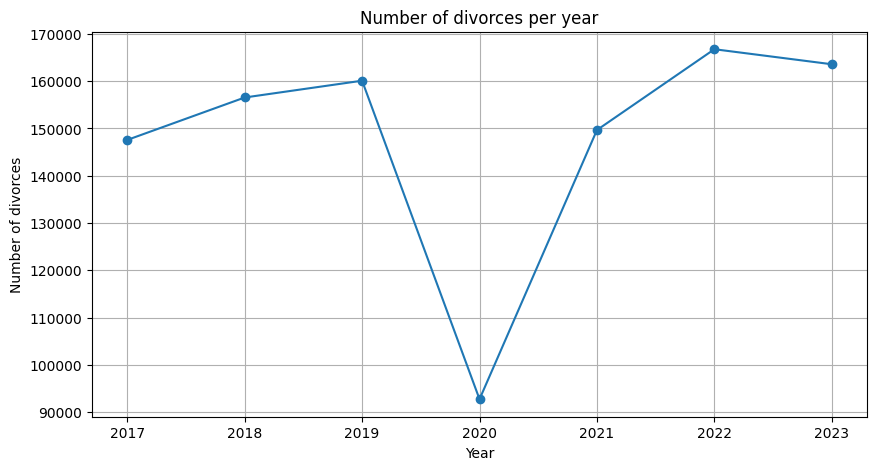

In [89]:
query = {
    "size": 0,
    "aggs": {
        "divorcios_por_año": {
            "terms": {
                "field": "divorce_final_order.year",
                "size": 100,
                "order": { "_key": "asc" }
            }
        }
    }
}

response = es.search(index="mexico-divorces", body=query)
data = response["aggregations"]["divorcios_por_año"]["buckets"]

years = [int(b["key"]) for b in data]
counts = [b["doc_count"] for b in data]

plt.figure(figsize=(10, 5))
plt.plot(years, counts, marker='o')
plt.title("Number of divorces per year")
plt.xlabel("Year")
plt.ylabel("Number of divorces")
plt.grid(True)
plt.show()


El gráfico anterior muestra los divorcios totales por año; se puede notar que en 2020 los divorcios disminuyeron drásticamente. Este evento podría deberse a la enfermedad causada por el COVID-19.


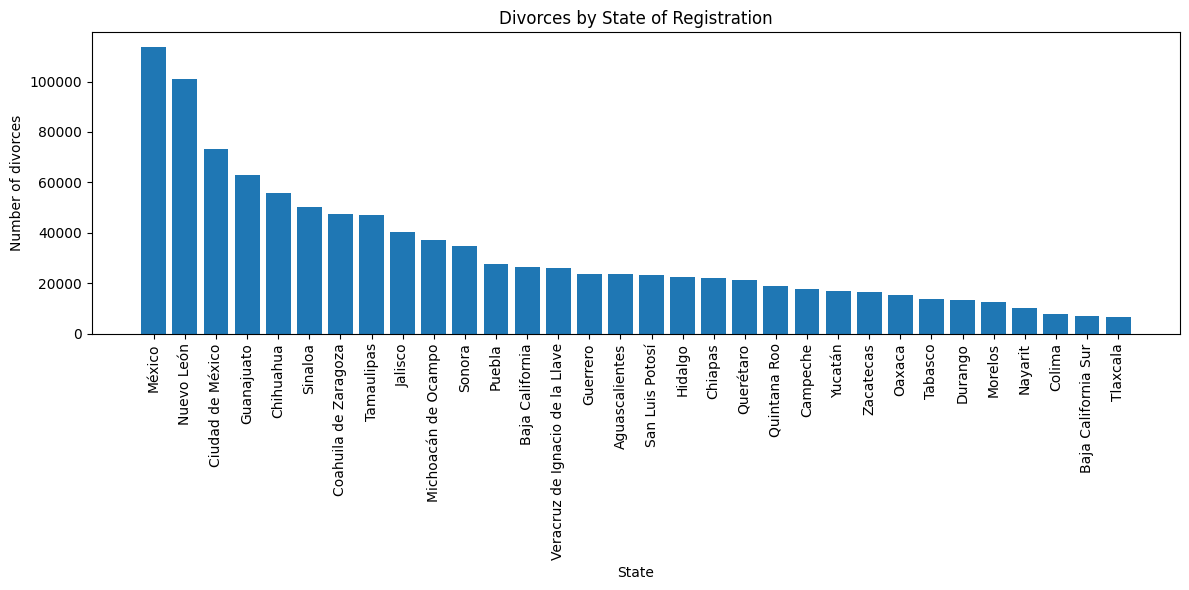

In [90]:
query = {
    "size": 0,
    "aggs": {
        "divorcios_por_estado": {
            "terms": {
                "field": "divorce_registration_location.state",
                "size": 32
            }
        }
    }
}

response = es.search(index="mexico-divorces", body=query)
data = response["aggregations"]["divorcios_por_estado"]["buckets"]

states = [b["key"] for b in data]
counts = [b["doc_count"] for b in data]

plt.figure(figsize=(12, 6))
plt.bar(states, counts)
plt.xticks(rotation=90)
plt.title("Divorces by State of Registration")
plt.xlabel("State")
plt.ylabel("Number of divorces")
plt.tight_layout()
plt.show()


Este gráfico muestra los estados con más divorcios, en orden de mayor a menor. Se observa que el “Estado de México” es el estado con mayor número de casos y “Tlaxcala” es el estado con menor número de casos.


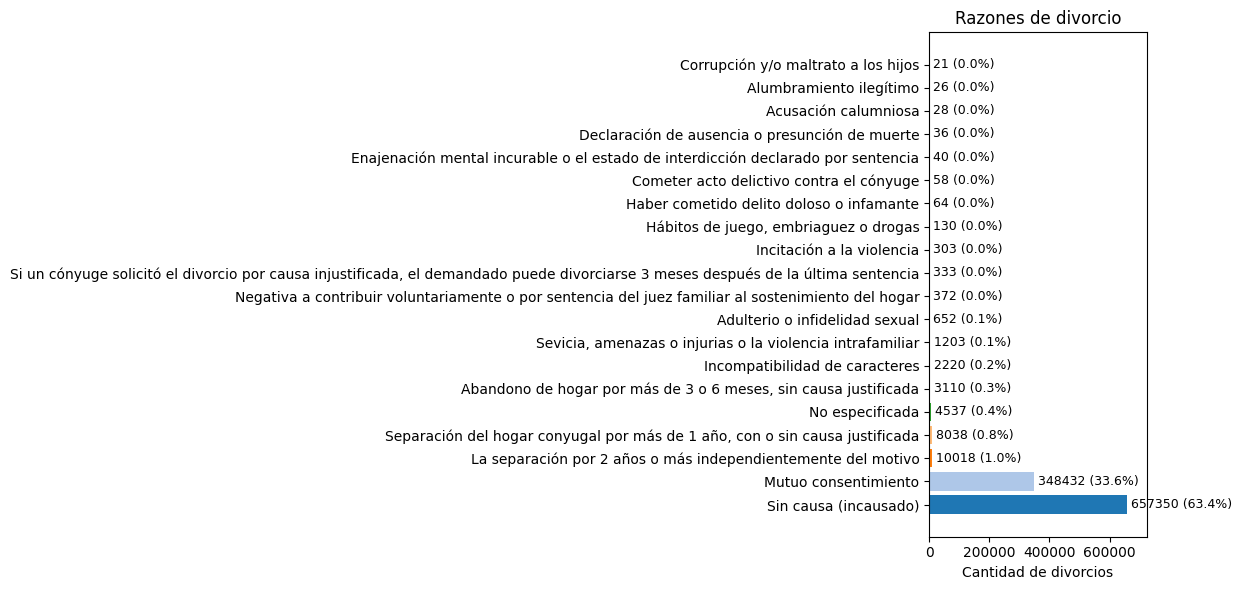

In [91]:
query = {
    "size": 0,
    "aggs": {
        "razones_de_divorcio": {
            "terms": {
                "field": "divorce_reason",
                "size": 20
            }
        }
    }
}

response = es.search(index="mexico-divorces", body=query)


data = response["aggregations"]["razones_de_divorcio"]["buckets"]
reasons = [b["key"] for b in data]
counts = [b["doc_count"] for b in data]


colors = plt.cm.tab20.colors[:len(reasons)]


fig, ax = plt.subplots(figsize=(12, 6))


ax.barh(reasons, counts, color=colors)


ax.set_xlabel("Cantidad de divorcios")
ax.set_title("Razones de divorcio")
ax.set_xlim(0, max(counts) * 1.1)  

for i, v in enumerate(counts):
    ax.text(v + max(counts) * 0.02, i, f'{v} ({v / sum(counts) * 100:.1f}%)', va='center', fontsize=9)

plt.tight_layout()
plt.show()

Este gráfico muestra las diferentes causas de divorcio, en orden de menor a mayor. Podemos ver que el 63.4% de los casos son “sin causa” o “no causados”.

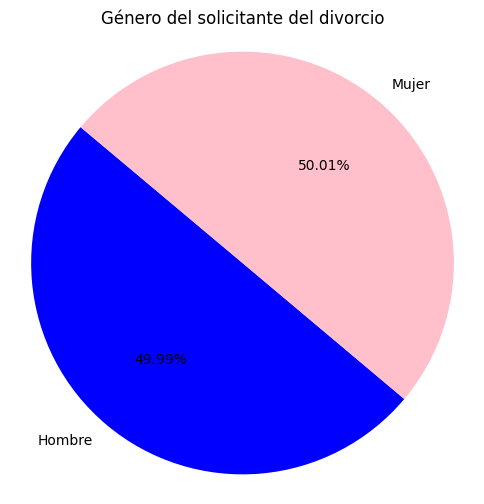

In [92]:
query = {
    "size": 0,
    "aggs": {
        "genero_peticionario": {
            "filters": {
                "filters": {
                    "Hombre": {
                        "bool": {
                            "should": [
                                {"term": {"divorcee_1.gender": "Hombre"}},
                                {"term": {"divorcee_2.gender": "Hombre"}}
                            ],
                            "minimum_should_match": 1
                        }
                    },
                    "Mujer": {
                        "bool": {
                            "should": [
                                {"term": {"divorcee_1.gender": "Mujer"}},
                                {"term": {"divorcee_2.gender": "Mujer"}}
                            ]
                        }
                    }
                }
            }
        }
    }
}

response = es.search(index="mexico-divorces", body=query)
buckets = response["aggregations"]["genero_peticionario"]["buckets"]

# Extraer etiquetas y valores
genders = list(buckets.keys())
counts = [buckets[key]["doc_count"] for key in genders]

colors = ["blue", "pink"]

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=genders, autopct='%0.2f%%', startangle=140, colors=colors)
plt.title("Género del solicitante del divorcio")
plt.axis('equal')  # Mantener forma circular
plt.show()


El gráfico muestra que el 61.3% de los divorcios son solicitados por hombres. Esto puede deberse a diferentes factores, como problemas conyugales o intereses e ideas diferentes.


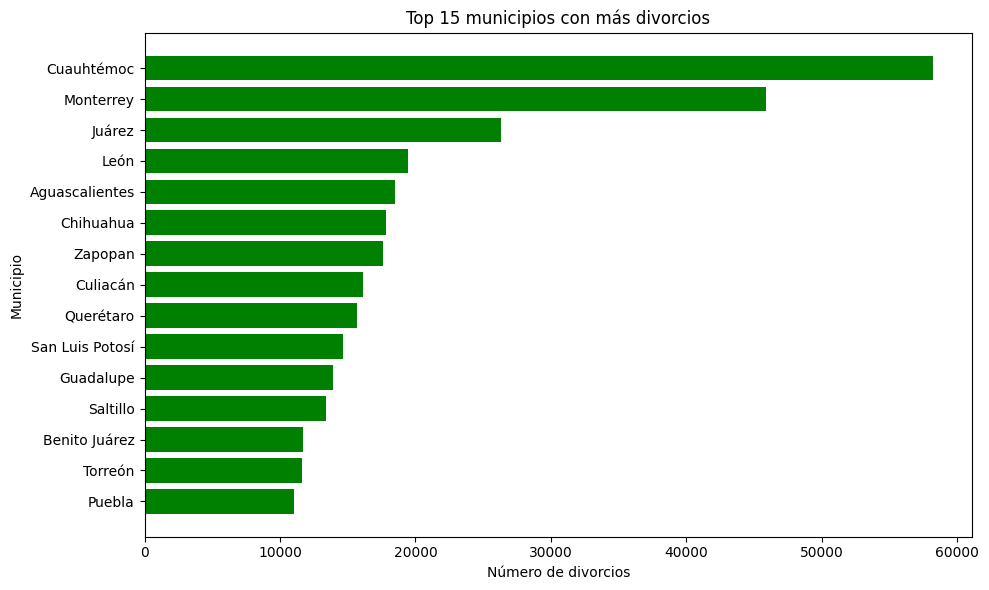

In [93]:
query = {
    "size": 0,
    "aggs": {
        "municipios_con_mas_divorcios": {
            "terms": {
                "field": "divorce_registration_location.municipality",
                "size": 15
            }
        }
    }
}

response = es.search(index="mexico-divorces", body=query)
data = response["aggregations"]["municipios_con_mas_divorcios"]["buckets"]

municipios = [b["key"] for b in data]
counts = [b["doc_count"] for b in data]

plt.figure(figsize=(10, 6))
plt.barh(municipios, counts, color="green")
plt.title("Top 15 municipios con más divorcios")
plt.xlabel("Número de divorcios")
plt.ylabel("Municipio")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


En el gráfico se puede ver cómo el municipio “Cuauhtémoc” perteneciente a Chihuahua es el municipio con mayor número de divorcios registrados. Cabe mencionar que Chihuahua es el quinto estado con más divorcios en México.


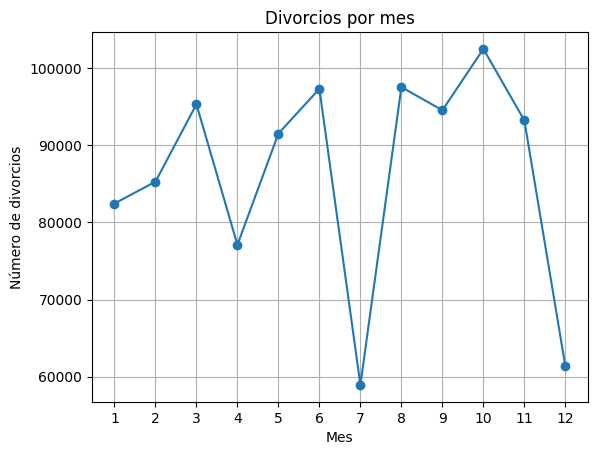

In [94]:
query = {
    "size": 0,
    "aggs": {
        "divorcios_por_mes": {
            "terms": {
                "field": "divorce_final_order.month",
                "size": 12,
                "order": { "_key": "asc" }
            }
        }
    }
}

response = es.search(index="mexico-divorces", body=query)
data = response["aggregations"]["divorcios_por_mes"]["buckets"]

months = [b["key"] for b in data]
counts = [b["doc_count"] for b in data]

plt.plot(months, counts, marker='o')
plt.title("Divorcios por mes")
plt.xlabel("Mes")
plt.ylabel("Número de divorcios")
plt.grid(True)
plt.xticks(months)
plt.show()


El gráfico muestra los divorcios totales por mes, siendo enero el número 1 y así sucesivamente hasta diciembre que es el número 12. Se puede observar que el mes número 10 (octubre) es el mes con más divorcios registrados. Mientras que julio (mes 7) y diciembre (mes 12) son los meses con menor número de divorcios registrados.


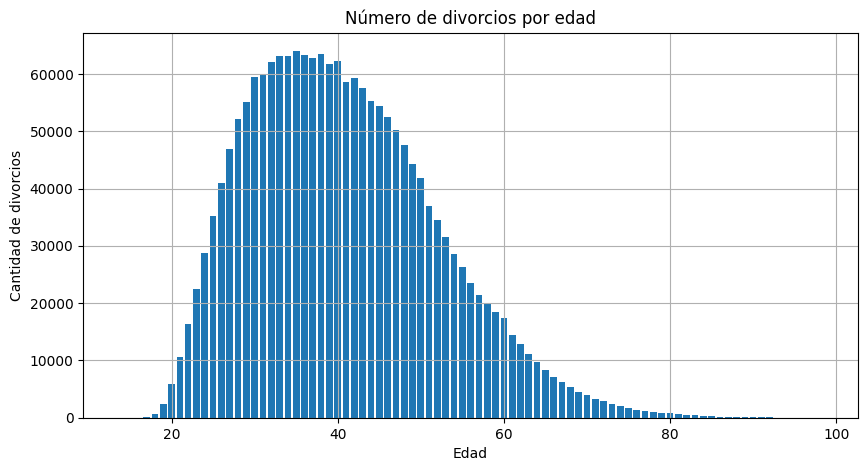

In [96]:
age_query = {
    "size": 0,
    "aggs": {
        "ages_1": {
            "terms": {
                "field": "divorcee_1.age",
                "size": 100,
                "order": {"_key": "asc"}
            }
        },
        "ages_2": {
            "terms": {
                "field": "divorcee_2.age",
                "size": 100,
                "order": {"_key": "asc"}
            }
        }
    }
}
age_res = es.search(index="mexico-divorces", body=age_query)
age_buckets = {}

for b in age_res["aggregations"]["ages_1"]["buckets"]:
    age_buckets[b["key"]] = age_buckets.get(b["key"], 0) + b["doc_count"]
for b in age_res["aggregations"]["ages_2"]["buckets"]:
    age_buckets[b["key"]] = age_buckets.get(b["key"], 0) + b["doc_count"]

ages = sorted(age_buckets.keys())
counts = [age_buckets[age] for age in ages]

plt.figure(figsize=(10, 5))
plt.bar(ages, counts)
plt.title("Número de divorcios por edad")
plt.xlabel("Edad")
plt.ylabel("Cantidad de divorcios")
plt.grid(True)
plt.show()

Este gráfico muestra los dirvorcios registrados en México del 2017 al 2023 dividos por edad de los divorciantes. Se puede ver que, en base al historico de divorcios, los mexicanos son más propensos a divorciarse entre las edades de 30 y 40 años 

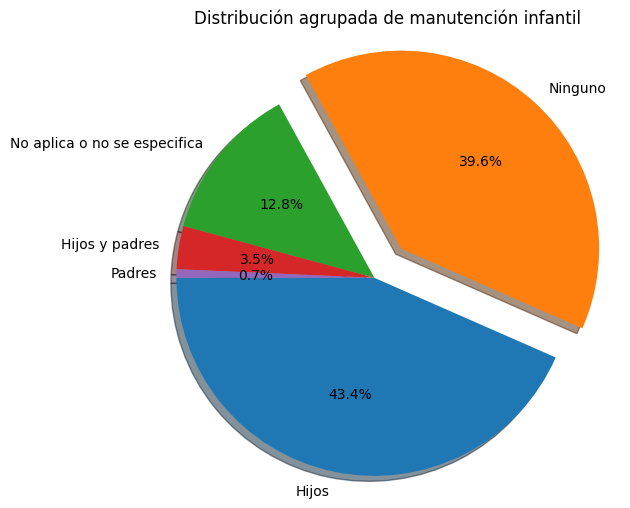

In [108]:
# Define mapping of raw keys to grouped categories
group_mapping = {
    "Hijos": "Hijos",
    "Hijos y Divorciante 1": "Hijos y padres",
    "Hijos y Divorciante 2": "Hijos y padres",
    "Ninguno":"Ninguno",
    "Divorciante 2":"Padres",
    "Divorciante 1":"Padres",
    "No aplica":"No aplica o no se especifica",
    "No especificado":"No aplica o no se especifica"
}

# Query Elasticsearch
maintenance_query = {
    "size": 0,
    "aggs": {
        "child_maintenance": {
            "terms": {
                "field": "child_maintenance",
                "size": 20
            }
        }
    }
}
maint_res = es.search(index="mexico-divorces", body=maintenance_query)

# Group and sum counts
grouped_counts = {}
for bucket in maint_res["aggregations"]["child_maintenance"]["buckets"]:
    original_key = bucket["key"]
    count = bucket["doc_count"]
    group = group_mapping.get(original_key, "unknown")
    grouped_counts[group] = grouped_counts.get(group, 0) + count

# Prepare data for plotting
labels = list(grouped_counts.keys())
sizes = list(grouped_counts.values())

# Plot
myexplode = [0, 0.2, 0, 0,0]
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', explode = myexplode, shadow = True, startangle=180)
plt.title("Distribución agrupada de manutención infantil")
plt.axis('equal')
plt.show()

El gráfico muestra la asignación de la pensión alimenticia en los divorcios de México entre los años 2017 y 2023. Como se muestra, en la mayoría de los casos la pensión cae en los mismos hijos conformando el 43.4% de los casos, hay un mínimo de casos en los que la pensión alimenticia es solamentes de los padre con un 0.7%. Lo que resulta preocupante es el 39.6% donde la pensión alimenticia no se le asigna a nadie.

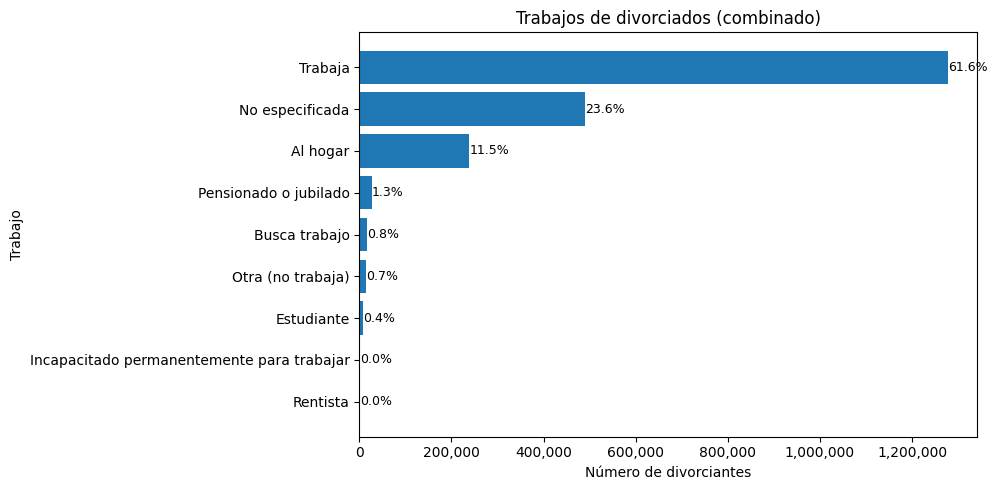

In [23]:

job_query = {
    "size": 0,
    "aggs": {
        "job_1": {
            "terms": {
                "field": "divorcee_1.dedication",
                "size": 20
            }
        },
        "job_2": {
            "terms": {
                "field": "divorcee_2.dedication",
                "size": 20
            }
        }
    }
}
job_res = es.search(index="mexico-divorces", body=job_query)
job_counts = {}
# Combination
for b in job_res["aggregations"]["job_1"]["buckets"]:
    job_counts[b["key"]] = job_counts.get(b["key"], 0) + b["doc_count"]
for b in job_res["aggregations"]["job_2"]["buckets"]:
    job_counts[b["key"]] = job_counts.get(b["key"], 0) + b["doc_count"]

job_sorted = sorted(job_counts.items(), key=lambda x: x[1], reverse=True)
jobs = [j[0] for j in job_sorted]
counts = [j[1] for j in job_sorted]

total = sum(counts)



plt.figure(figsize=(10, 5))
bars = plt.barh(jobs, counts, color='skyblue')
plt.barh(jobs, counts)
plt.title("Trabajos de divorciados (combinado)")
plt.xlabel("Número de divorciantes")
plt.ylabel("Trabajo")
plt.gca().invert_yaxis()
# Set x-axis in steps of 200,000
plt.gca().xaxis.set_major_locator(MultipleLocator(200000))

# Set x-axis formatter to use real numbers with commas
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
# Add percentage labels at the end of each bar
for bar, count in zip(bars, counts):
    percent = (count / total) * 100
    width = bar.get_width()
    plt.text(width + 500, bar.get_y() + bar.get_height() / 2,
             f"{percent:.1f}%", va='center', fontsize=9)
plt.tight_layout()
plt.show()

Entre los divorcios registrados se tiene una gran mayoría de divorciantes que trabajan (61.6%), y, que por ende, son más independientes. Por otro lado, hay un porcentaje muy bajo de personas desempleadas que se han divorciado (0.7%), o otro pequeño porcentaje de personas que están buscaban trabajo (0.8%) 

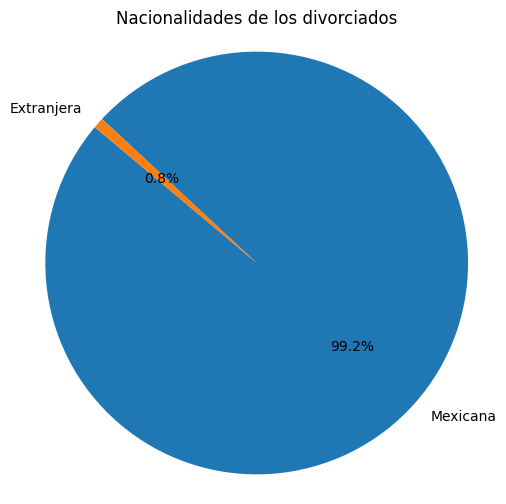

In [24]:
nat_query = {
    "size": 0,
    "aggs": {
        "nat_1": {
            "terms": {
                "field": "divorcee_1.nationality",
                "size": 10
            }
        },
        "nat_2": {
            "terms": {
                "field": "divorcee_2.nationality",
                "size": 10
            }
        }
    }
}
nat_res = es.search(index="mexico-divorces", body=nat_query)
nat_counts = {}
# Combination
for b in nat_res["aggregations"]["nat_1"]["buckets"]:
    nat_counts[b["key"]] = nat_counts.get(b["key"], 0) + b["doc_count"]
for b in nat_res["aggregations"]["nat_2"]["buckets"]:
    nat_counts[b["key"]] = nat_counts.get(b["key"], 0) + b["doc_count"]

labels = list(nat_counts.keys())
sizes = list(nat_counts.values())

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Nacionalidades de los divorciados")
plt.axis('equal')
plt.show()

Entre todos los divoricios registrados entre 2017 y 2023 en méxico, solo el 0.8% representa a los divorciantes provenientes de otros países.

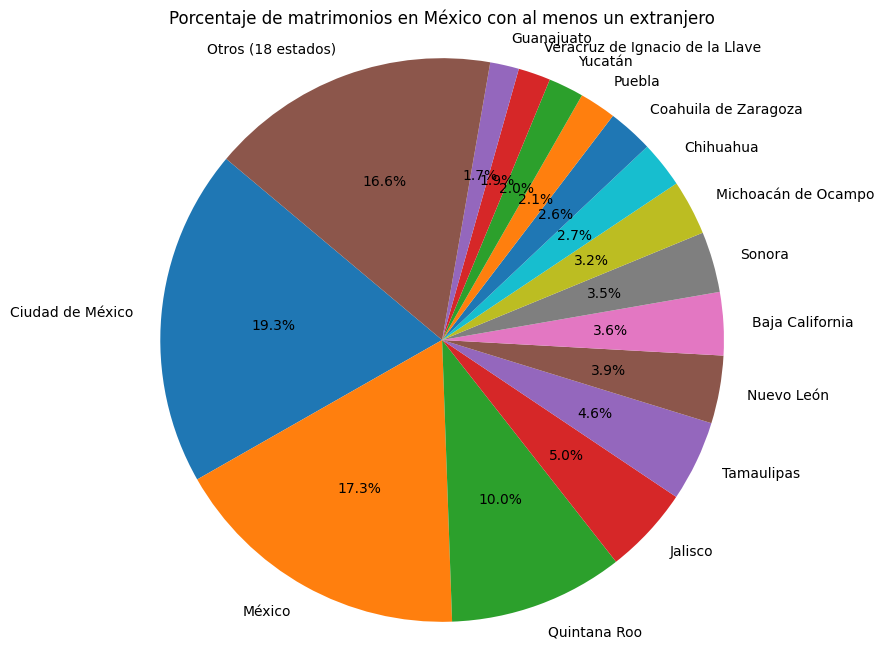

In [34]:

state_query = {
    "size": 0,
    "query": {
        "bool": {
            "should": [
                { "term": { "divorcee_1.nationality": "Extranjera" } },
                { "term": { "divorcee_2.nationality": "Extranjera" } }
            ]
        }
    },
    "aggs": {
        "marriage_state": {
            "terms": {
                "field": "marriage_registration_location.state",
                "size": 100
            }
        }
    }
}

# Query Elasticsearch
res = es.search(index="mexico-divorces", body=state_query)

# Merge buckets from both aggregations
state_counts = {}

# Second aggregation
for b in res["aggregations"]["marriage_state"]["buckets"]:
    state_counts[b["key"]] = state_counts.get(b["key"], 0) + b["doc_count"]

# # Prepare data for pie chart
# labels = list(state_counts.keys())
# sizes = list(state_counts.values())

# # Optional: sort descending by size
# sorted_data = sorted(zip(labels, sizes), key=lambda x: x[1], reverse=True)
# labels, sizes = zip(*sorted_data)

# # Pie chart
# plt.figure(figsize=(8, 8))
# plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
# plt.title("Porcentaje de divorcios con al menos un extranjero por estado")
# plt.axis('equal')
# plt.show()

# Combine small slices into "Otros"
top_n = 15  # show top 8 states
sorted_data = sorted(state_counts.items(), key=lambda x: x[1], reverse=True)
top_states = sorted_data[:top_n]
otros = sum([c for _, c in sorted_data[top_n:]])

labels = [s[0] for s in top_states] + ["Otros (18 estados)"]
sizes = [s[1] for s in top_states] + [otros]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Porcentaje de matrimonios en México con al menos un extranjero")
plt.axis('equal')
plt.show()

De ese 0.8% de divorcios en los que los extrangeros fueron partícipes, la gran mayoría se casaron o en la Ciudad de México(19.3%), el Estado de México(17.3%) y Quintana Roo (10%). Lo que podría indicar que esos estados son de gran atractivo turístico para otros países.